# Adaptive (RLS/MSPI) GPC with Rate Constraints

* Author: Hamza El-Kebir
* Date: Nov 15, 2019

**Description**

This Python code contains an implementation of SISO GPC with self-tuning properties and rate constraints. Press <kbd>Shift+Enter</kbd> to run cells in Jupyter Notebooks. A brief list of tuning parameters and sources can be found below.

In [117]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.signal
from typing import Optional

In [118]:
mpl.rcParams["figure.figsize"] = 10, 5

In [119]:
class GPC(object):
    def __init__(self):
        self.forced_response = self.G
        self.free_response = self.f
        self.control_increment = self.du
        self.control_increment_rate_constrained = self.du_rc

    def G(self,
                   A: np.ndarray,
                   B: np.ndarray,
                   Nu: Optional[int] = None) -> np.ndarray:

        if Nu is None:
            Nu = 1

        gfunc = lambda k : g[k] if 0 <= k < Nu else 0
        Afunc = lambda k : A[k] if 0 <= k < len(A) else 0
        Bfunc = lambda k : B[k] if 0 <= k < len(B) else 0

        g = [B[0]]
        for k in range(1,Nu):
            Aterm = -np.sum([Afunc(i)*gfunc(k-i) for i in range(1, k+1)])
            Bterm = np.sum([Bfunc(i) for i in range(k+1)])
            g.append(Aterm+Bterm)

        G = np.zeros((Nu,Nu))
        for i in range(Nu):
            G[i] = np.hstack([g[:i+1][::-1],np.zeros(Nu-(i+1))])

        return G

    def f(self,
          A: np.ndarray,
          B: np.ndarray,
          y: np.ndarray,
          du: np.ndarray,
          Nu: Optional[int] = None) -> np.ndarray:

        if Nu is None:
            Nu = 1

        gfunc = lambda k : g[k] if 0 <= k < Nu else 0
        yfunc = lambda k : y[k] if 0 <= k < Nu else 0
        dufunc = lambda k : du[k] if 0 <= k < Nu else 0
        Afunc = lambda k : A[k] if 0 <= k < len(A) else 0
        Bfunc = lambda k : B[k] if 0 <= k < len(B) else 0

        y = list(np.copy(y))

        f = y
        Aterm = sum([(Afunc(i)-Afunc(i+1))*yi for i, yi in zip(range(len(A)), y[::-1][:len(A)])])
        Bterm = sum([bi*dui for bi, dui in zip(B[1:], du[::-1][:len(B[1:])])])

        y.append(Aterm + Bterm)
        f = [Aterm + Bterm]
        for k in range(Nu-1):
            Aterm = sum([(Afunc(i)-Afunc(i+1))*yi for i, yi in zip(range(len(A)), y[::-1][:len(A)])])
            y.append(Aterm)
            f.append(Aterm)

        return np.array(f).reshape((len(f), 1))

    def du(self,
           G: np.ndarray,
           f: np.ndarray,
           w: np.ndarray,
           l: np.float32 = 0.8):

        if len(w) < len(f):
            w = np.hstack([w.flatten(), np.zeros(len(f)-len(w))])
            w = w.reshape((len(f), 1))
        else:
            w = w[:len(f)].reshape((len(f), 1))

        u = np.linalg.pinv(G.T.dot(G) + l*np.eye(G.shape[0])).dot(G.T).dot(w-f)

        return u

    def du_rc(self,
              G: np.ndarray,
              f: np.ndarray,
              w: np.ndarray,
              lo: np.ndarray,
              hi: np.ndarray,
              l: np.float32 = 0.8):

        duk = self.du(G, f, w, l)

        if isinstance(lo, float) or isinstance(lo, int):
            lo = np.array([lo])

        if isinstance(hi, float) or isinstance(hi, int):
            hi = np.array([hi])

        lo = np.pad(lo, (0,len(duk)-len(lo)), 'edge')
        hi = np.pad(hi, (0,len(duk)-len(hi)), 'edge')

        if np.clip(duk[0,0], lo[0], hi[0]) != duk[0,0]:
            if all([np.clip(duk[1:,:][i], lo[0], hi[0]) == duk[1:,:][i] for i in range(len(duk[1:,:]))]):
                duk[0,0] = np.clip(duk[0,0], lo[0], hi[0])
        if len(np.where(np.clip(duk, lo, hi).flatten() != duk.flatten())[0]) > 0:
            satidx = np.where(np.clip(duk.flatten(), lo, hi).flatten() != duk.flatten())[0]
            H = np.linalg.pinv(G.T.dot(G) + l*np.eye(G.shape[0]))
            a =  np.clip(duk.flatten(), lo, hi)[np.clip(duk.flatten(), lo, hi) != duk.flatten()]
            a = a.reshape(a.shape[0], 1)
            m = [(a[i]-duk[i2,0])/H[i2,i2] for i, i2 in enumerate(satidx)]

            for i, i2 in enumerate(satidx):
                ej = np.zeros((H.shape[0],1))
                ej[i2,0] = 1
                duk += H.dot(m[i]*ej)

        duk = np.clip(duk.flatten(), lo, hi).reshape((len(duk), 1))
        return duk

In [120]:
class RLS(object):
    def __init__(self, lenA, lenB, alphat=1):
        self.lenA = lenA
        self.lenB = lenB
        self.alphat = alphat
        self.phi, self.part = self.phi0()
        self.P = self.P0()
        self.theta = self.theta0()

    def phi0(self):
        phi0_y = np.zeros((self.lenA-1,1))
        phi0_u = np.zeros((self.lenB,1))
        return (np.vstack((phi0_y, phi0_u)), (self.lenA-1, self.lenB))

    def P0(self, C=1e6):
        return C*np.eye(self.lenA-1+self.lenB)

    def theta0(self):
        return np.zeros((self.lenA-1+self.lenB,1))

    def update_phi(self, y, u):
        self.phi = np.vstack((-y, self.phi[1:self.part[0]-1], u, self.phi[self.part[0]:-1]))

    def update_theta(self, y):
        self.L = (self.P.dot(self.phi)) / (1/self.alphat + self.phi.T.dot(self.P.dot(self.phi)))
        self.theta = self.theta + self.L.dot(y - self.theta.T.dot(self.phi))

    def update_P(self):
        self.P =  self.P - self.L.dot(self.phi.T.dot(self.P))

In [121]:
gpc = GPC()

# Verification with Camacho 4.4
G = gpc.G(A=[1,-0.8],B=[0.4, 0.6],Nu=3)
f = gpc.f(A=[1,-0.8],B=[0.4, 0.6],y=[0,0],du=[0],Nu=3)
w = np.ones((3,1))
du = gpc.du(G, f, w, l=0.8)
alpha = -0.2*np.ones(3)
beta = 0.2*np.ones(3)
du_rc = gpc.du_rc(G, f, w, alpha, beta, l=0.8)
print("G =\n", G)
print()
print("f =\n", f)
print()
print("(G^T G + l I)^-1 G^T for l = 0.8 =\n")
print(np.linalg.pinv(G.T.dot(G) + 0.8*np.eye(G.shape[0])).dot(G.T))
print()
print("du =\n", du)
print("du_rc =\n", du_rc)

G =
 [[0.4   0.    0.   ]
 [1.32  0.4   0.   ]
 [2.056 1.32  0.4  ]]

f =
 [[0.]
 [0.]
 [0.]]

(G^T G + l I)^-1 G^T for l = 0.8 =

[[ 0.13339114  0.28591717  0.14710632]
 [-0.1542736  -0.16484019  0.28591717]
 [-0.02942126 -0.1542736   0.13339114]]

du =
 [[ 0.56641463]
 [-0.03319662]
 [-0.05030372]]
du_rc =
 [[ 0.2       ]
 [-0.03319662]
 [-0.05030372]]


<ipython-input-119-ae3c6c546240>:101: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if len(np.where(np.clip(duk, lo, hi).flatten() != duk.flatten())[0]) > 0:


In [122]:
def plot_GPC(A=[1,-0.8], B=[0.4,0.6], lenA=2, lenB=2, Nu=3, lo=-.5, hi=.5, N=100, sysID=False):
    gpc = GPC()
    rls1 = RLS(lenA, lenB)

    # w = scipy.signal.square(0.3*np.arange(N),0.5)
    w = scipy.signal.square(0.3*np.arange(N),0.5) + scipy.signal.square(0.1*np.arange(N),0.5) - scipy.signal.square(.6*np.arange(N),0.5)

    v2 = 1e-1*np.sin((N/3)*(np.arange(N)/N)*2*np.pi)

    lo = -0.5
    hi = 0.5
    y = list(np.zeros(Nu-1))
    y_hat = []
    du = list(np.zeros(Nu-2))
    theta1 = []

    for k in range(N):
        G = gpc.forced_response(A=A,B=B,Nu=Nu)
        f = gpc.free_response(A=A,B=B,y=y,du=du,Nu=Nu)

        if not sysID:
            Aest = A
            Best = B
            Gest = G
            fest = f
        else:
            Aest = np.hstack(([1], rls1.theta[:rls1.lenA-1].flatten()))
            Best = rls1.theta[rls1.lenB-1:].flatten()

            Gest = gpc.forced_response(A=Aest,B=Best,Nu=Nu)
            fest = gpc.free_response(A=Aest,B=Best,y=y,du=du,Nu=Nu)

        duk = gpc.control_increment_rate_constrained(Gest, fest, w[k:], lo, hi, l=0.8)
        duk += v2[k]
        du.append(duk[0,0])

        yk = (G.dot(duk)+f)[0,0]
        yk_hat = rls1.theta.T.dot(np.vstack([-np.asarray(y[::-1][:rls1.lenA-1]).reshape((rls1.lenA-1,1)), du[-1], duk[0:rls1.lenB-1]]))[0,0]

        y.append(yk)
        y_hat.append(yk_hat)
        theta1.append(rls1.theta)

        rls1.update_theta(yk)
        rls1.update_P()
        rls1.update_phi(yk, duk[0,0])

    plt.plot(w[-N:], label='Reference')
    plt.plot(y[-N:], label='Output')
    plt.plot(du[-N:], label='Control')
    plt.axhline(lo, color='k', linestyle=':', label='Lower bound')
    plt.axhline(hi, color='k', linestyle=':', label='Upper bound')
    plt.legend()
    plt.tight_layout()
    plt.show()

    if sysID:
        plt.plot(np.asarray(theta1)[:,0], label='$\hat{a}$')
        plt.plot(np.asarray(theta1)[:,2], label='$\hat{b}_1$')
        plt.plot(np.asarray(theta1)[:,1], label='$\hat{b}_2$')
        plt.axhline(-.8, linestyle=':', label='$a$', color=mpl.cm.tab10(0))
        plt.axhline(.4, linestyle=':', label='$b_1$', color=mpl.cm.tab10(1))
        plt.axhline(.6, linestyle=':', label='$b_2$', color=mpl.cm.tab10(2))
        plt.legend()
        plt.tight_layout()
        plt.show()

    return dict(y=y, yhat=y_hat, theta=theta1, w=w)

### Usage

Run the function below with different SISO polynomial models (cf. *Camacho and Bordons (2007)*<sup>1</sup> Sec. 4.4). The GPC controller includes the rate-constraints as defined in *Tsang and Clarke (1988)*<sup>2</sup>, recursive least squares (RLS) parameter identification as outlined in *Ljung and Söderström (1983)*<sup>3</sup> as well as multi-step predictive identification (MSPI), as described in *Haber et al. (2011)*<sup>4</sup>.

#### Tuning parameters

* *Control costing horizon*: $N_u$ (`Nu`); number of costed control increments in the future (*tightness* of control in relation to future reference).
* *Control polynomial order*: $N_B$ (`lenB`); if the polynomial order is greater than the system order, an MSPI-type control will be used with $N_B + 1 - N_{B,act}$-step ahead control (*predictive* control horizon).
* *Slew constraints*: $\alpha, \beta$ (`lo, hi`): hard constraints on control magnitude.

### References

<sup>1</sup> E. F. Camacho and C. Bordons. Model Predictive Control. *Advanced Textbooks in Control and Signal Processing*. Springer London, London, 2007. ISBN 978-1-85233-694-3 978-0-85729-398-5. doi: 10.1007/978-0-85729-398-5.

<sup>2</sup> T.T.C. Tsang and D.W. Clarke. Generalised predictive control with input constraints. *IEE Proceedings D Control Theory and Applications*, 135(6):451, 1988. ISSN 01437054. doi: 10.1049/ip-d.1988.0069.

<sup>3</sup> Lennart Ljung and Torsten Söderström. *Theory and Practice of Recursive Identification*. Number 4 in The MIT Press Series in Signal Processing, Optimization, and Control. MIT Press, Cambridge, Mass, 1983. ISBN 978-0-262-12095-1.

<sup>4</sup> Robert Haber, Ruth Bars, and Ulrich Schmitz. *Predictive Control in Process Engineering: From the Basics to the Applications*. Wiley-VCH Verlag GmbH & Co. KGaA, Weinheim, Germany, September 2011. ISBN 978-3-527-63624- 2 978-3-527-31492-8. doi: 10.1002/9783527636242.


<ipython-input-119-ae3c6c546240>:101: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if len(np.where(np.clip(duk, lo, hi).flatten() != duk.flatten())[0]) > 0:


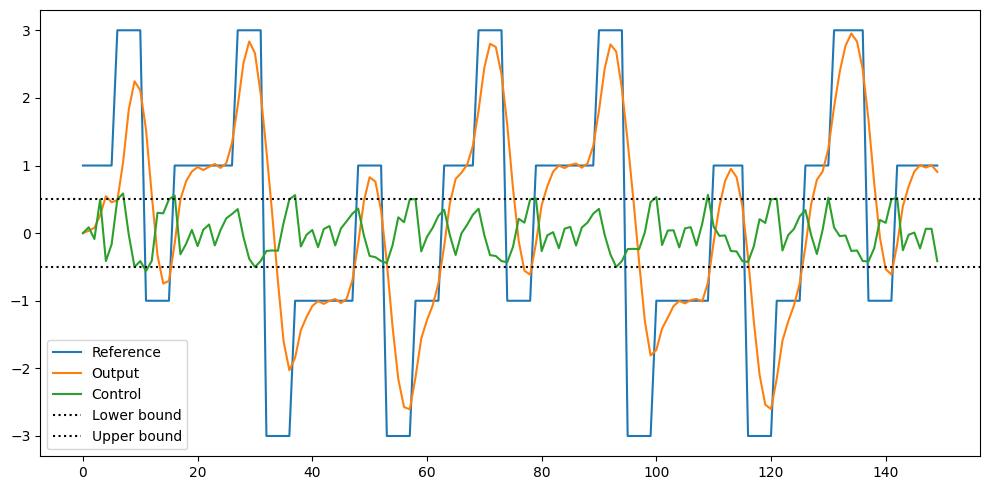

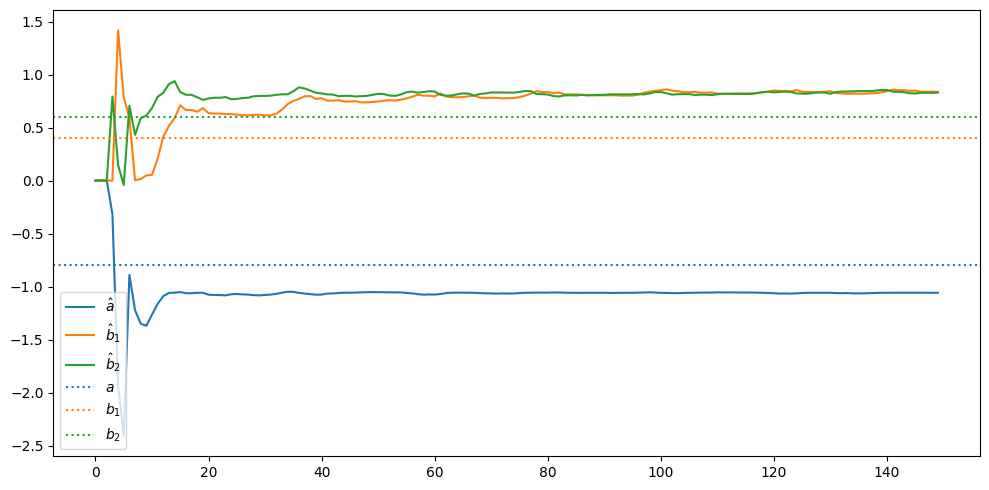

In [123]:
_ = plot_GPC(A=[1,-0.8], B=[0.4,0.6], lenA=2, lenB=2, Nu=3, lo=-.5, hi=.5, N=150, sysID=True)

In [163]:
import numpy as np
from numpy import convolve
from scipy.signal import lfilter, deconvolve


class LRPIModel:
    def __init__(self):
        pass

    def batlrpi(self, y, U, N, D, T):
        na = N[0]
        nb = N[1]
        k = N[2]
        N1 = N[3]
        N2 = N[4]

        y = np.array(y).flatten()
        u = np.array(U).flatten()

        tol = 1e-3
        err = 1
        Nmax = len(y)
        theta = np.zeros(na+nb)

        while err > tol:
            if na > 0:
                L = self.eqivl(np.concatenate(
                    ([1], theta[nb:na+nb])), D, T, N1, N2)
            else:
                L = self.eqivl([1, 0], D, T, N1, N2)

            yf = lfilter(convolve(L, D), T, y)
            uf = lfilter(convolve(L, D), T, u)

            n = max(na, nb+k-1)
            X = uf[n-k:Nmax-k].reshape(-1, 1)

            for i in range(1, nb):
                X = np.hstack((X, uf[n-i-k:Nmax-i-k].reshape(-1, 1)))

            for i in range(na):
                X = np.hstack((X, -yf[n-i-1:Nmax-i-1].reshape(-1, 1)))

            Y = yf[n:Nmax]
            thetanew = np.linalg.lstsq(X, Y, rcond=None)[0]
            err = np.linalg.norm(theta - thetanew, 1) / \
                max(np.linalg.norm(theta, 1), 1e-6)
            theta = thetanew

        # bhat = theta[nb-1::-1]
        bhat = np.concatenate(([0], theta[:nb]))
        ahat = np.concatenate(([1], theta[nb:na+nb]))

        return ahat, bhat, L

    def eqivl(self, a, D, T, N1, N2):
        E = lfilter(np.ones(T), convolve(a, D), [1] + [0] * N2)
        m = convolve(E[:N1], E[N1-1::-1])

        for i in range(N1, N2):
            mi = convolve(E[:i+1], E[i::-1])
            m = np.pad(m, (1, 1), 'constant') + mi

        L = self.spectr(m)
        L = L / np.sum(L)

        return L

    def spectr(self, m, tol=1e-3):
        lm = len(m)
        x = np.array([1] + [0] * (lm // 2))
        r = 1

        while r > tol:
            x, rem = deconvolve(m, x)
            lx = len(x)
            x = x[::-1] / x[lx-1]
            r = np.linalg.norm(rem, 1)

        return x


In [165]:
import numpy as np

lrpi = LRPIModel()
# Define the ARX model parameters
Ap = [1, -0.7]
Bp = [0.3, 0.5]

# Define input signal u
u = np.ones(500)

# Initialize the output signal y
y = np.ones(500)

# Simulate the system
for i in range(2, 500):
    y[i] = -Ap[1] * y[i-1] + Bp[0] * u[i-1] + Bp[1] * u[i-2]

# Define the LRPI model order N, delay D, and lag T
N = [1, 2, 1, 1, 3]
D = 1
T = 1

ahat, bhat, L = lrpi.batlrpi(y, u, N, D, T)

print("Estimated ahat:", ahat)
print("Estimated bhat:", bhat)

Estimated ahat: [ 1.        -0.7088384]
Estimated bhat: [0.         0.62544805 0.15101381]


In [169]:
def plot_GPC_LRPI(A=[1,-0.8], B=[0.4,0.6], lenA=2, lenB=2, Nu=3, lo=-.5, hi=.5, N=100, sysID=False):
    gpc = GPC()
    rls1 = RLS(lenA, lenB)
    lrpi = LRPIModel()

    # w = scipy.signal.square(0.3*np.arange(N),0.5)
    w = scipy.signal.square(0.3*np.arange(N),0.5) + scipy.signal.square(0.1*np.arange(N),0.5) - scipy.signal.square(.6*np.arange(N),0.5)

    v2 = 1e-1*np.sin((N/3)*(np.arange(N)/N)*2*np.pi)

    lo = -0.5
    hi = 0.5
    y = list(np.zeros(Nu-1))
    y_hat = []
    du = list(np.zeros(Nu-2))
    theta1 = []

    for k in range(N):
        G = gpc.forced_response(A=A,B=B,Nu=Nu)
        f = gpc.free_response(A=A,B=B,y=y,du=du,Nu=Nu)

        if not sysID or k<=3:
            Aest = A
            Best = B
            Gest = G
            fest = f
        else:
            Aest,Best,_ = lrpi.batlrpi(y[:k],du[:k],N=[1,2,1,1,3],D=1,T=1)
            # Aest2 = np.hstack(([1], rls1.theta[:rls1.lenA-1].flatten()))
            # Best2 = rls1.theta[rls1.lenB-1:].flatten()

            # print('Aest is ', Aest)
            # print('Aest2 is ', Aest2)
            # print('Best is ', Best)
            # print('Best2 is ', Best2)

            Gest = gpc.forced_response(A=Aest,B=Best,Nu=Nu)
            fest = gpc.free_response(A=Aest,B=Best,y=y,du=du,Nu=Nu)

        duk = gpc.control_increment_rate_constrained(Gest, fest, w[k:], lo, hi, l=0.8)
        duk += v2[k]
        du.append(duk[0,0])

        yk = (G.dot(duk)+f)[0,0]
        yk_hat = rls1.theta.T.dot(np.vstack([-np.asarray(y[::-1][:rls1.lenA-1]).reshape((rls1.lenA-1,1)), du[-1], duk[0:rls1.lenB-1]]))[0,0]

        y.append(yk)
        y_hat.append(yk_hat)
        theta1.append(rls1.theta)

        rls1.update_theta(yk)
        rls1.update_P()
        rls1.update_phi(yk, duk[0,0])

    plt.plot(w[-N:], label='Reference')
    plt.plot(y[-N:], label='Output')
    plt.plot(du[-N:], label='Control')
    plt.axhline(lo, color='k', linestyle=':', label='Lower bound')
    plt.axhline(hi, color='k', linestyle=':', label='Upper bound')
    plt.legend()
    plt.tight_layout()
    plt.show()

    if sysID:
        plt.plot(np.asarray(theta1)[:,0], label='$\hat{a}$')
        plt.plot(np.asarray(theta1)[:,2], label='$\hat{b}_1$')
        plt.plot(np.asarray(theta1)[:,1], label='$\hat{b}_2$')
        plt.axhline(-.8, linestyle=':', label='$a$', color=mpl.cm.tab10(0))
        plt.axhline(.4, linestyle=':', label='$b_1$', color=mpl.cm.tab10(1))
        plt.axhline(.6, linestyle=':', label='$b_2$', color=mpl.cm.tab10(2))
        plt.legend()
        plt.tight_layout()
        plt.show()

    return dict(y=y, yhat=y_hat, theta=theta1, w=w)

<ipython-input-119-ae3c6c546240>:101: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if len(np.where(np.clip(duk, lo, hi).flatten() != duk.flatten())[0]) > 0:


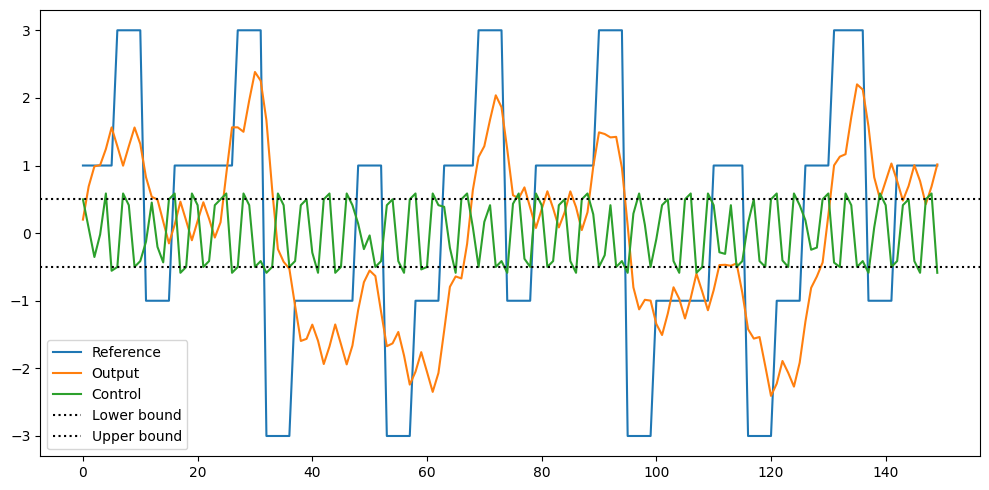

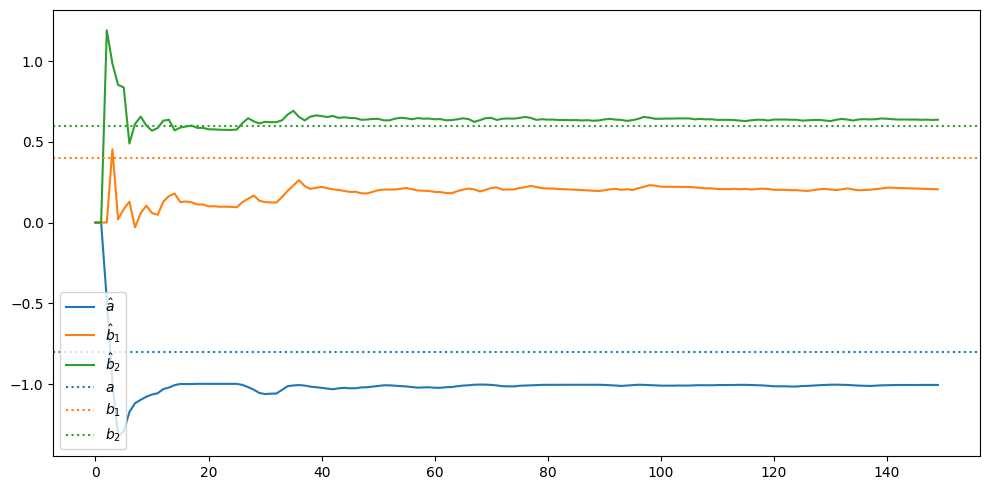

In [170]:
_ = plot_GPC_LRPI(A=[1,-0.8], B=[0.4,0.6], lenA=2, lenB=2, Nu=3, lo=-.5, hi=.5, N=150, sysID=True)